<a href="https://colab.research.google.com/github/DMaraboli/Challenge_TelecomX_2/blob/main/Challenge_TelecomX_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Cancelación de Clientes (Churn) en TelecomX

En este informe se detalla el proceso de análisis exploratorio, preprocesamiento, modelado y optimización de un conjunto de datos relacionado con clientes de la empresa TelecomX, con el objetivo de predecir la cancelación (*churn*).

---

## 1. Extracción y Preparación Inicial de Datos

Se cargan los datos, se eliminan columnas innecesarias y se realiza una primera inspección.

In [1]:
import pandas as pd

datos = pd.read_csv('/content/datos.csv')
datos.head()

,customerID,Churn,Male,Female,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_diarias,Numero_servicios
0,0002-ORFBO,0,0,1,0,1,1,9,1,0,...,1,1,0,One year,1,Mailed check,65.6,593.30,2.19,5
1,0003-MKNFE,0,1,0,0,0,0,9,1,1,...,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,2.00,4
2,0004-TLHLJ,1,1,0,0,0,0,4,1,0,...,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.46,3
3,0011-IGKFF,1,1,0,1,1,0,13,1,0,...,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.27,6
4,0013-EXCHZ,1,0,1,1,1,0,3,1,0,...,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.80,4


In [2]:
datos.drop(columns='customerID',axis=1,inplace=True)

Se elimina `customerID` por ser un identificador único que no aporta valor predictivo.

---

## 2. Análisis Exploratorio de Datos (EDA)

En esta etapa se analiza la relación entre las variables y la variable objetivo `Churn` (0 = Permanece, 1 = Cancela).

### 2.1. Variables categóricas

Se genera un gráfico de barras que muestra la proporción de cancelaciones por cada categoría.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = {'Permanece': '#4975c6', 'Cancela': '#ff8176'}

def grafico_columnas_categoricas (columna):
  valores_unicos = len(datos[columna].unique())
  churn_by = datos.groupby(columna)['Churn'].value_counts(normalize=True).reset_index()
  churn_by['Churn'] = churn_by['Churn'].map({0: 'Permanece', 1: 'Cancela'})
  plt.figure(figsize=(8, 5))
  ax = sns.barplot(
                  x=columna,
                  y='proportion',
                  hue='Churn',
                  data=churn_by,
                  palette=palette
                  )
  for p in ax.patches:
    height = p.get_height()
    if height > 0:
      ax.text(
              p.get_x() + p.get_width() / 2,
              height + 0.01,
              f'{height:.1%}',
              ha='center',
              va='bottom',
              fontsize=10
            )
  plt.legend(title='Churn', loc='upper right')
  plt.ylabel('Proporción')
  plt.xlabel(columna)
  if valores_unicos <= 2:
    plt.xticks([0, 1], ['No', 'Sí'])
  plt.title(f'Proporción de cancelaciones según {columna}')
  sns.despine()
  plt.tight_layout()
  plt.show()

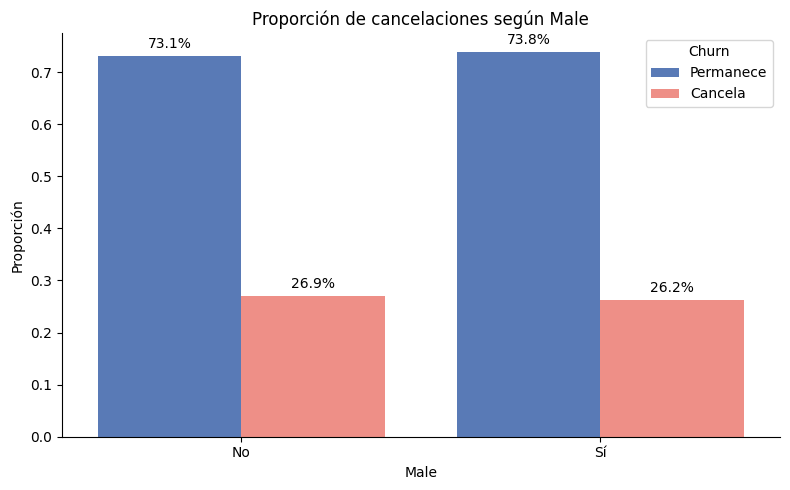

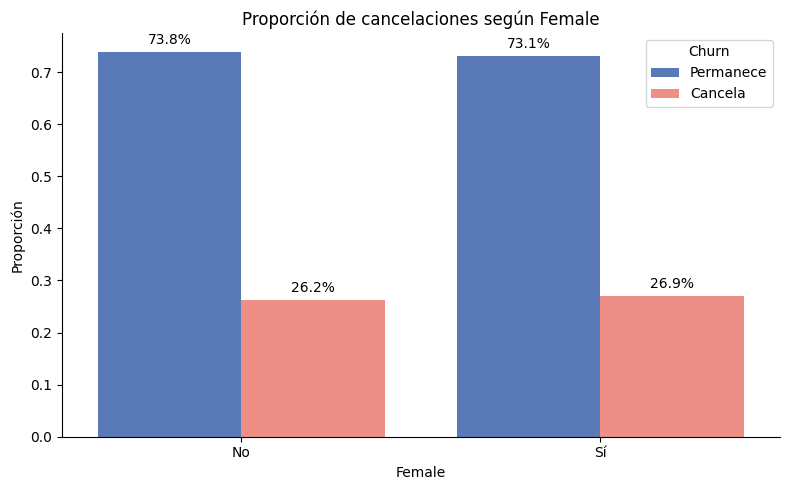

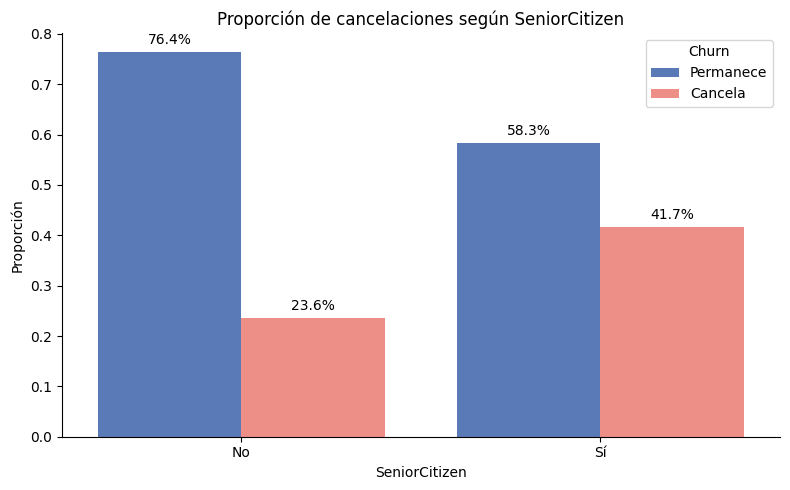

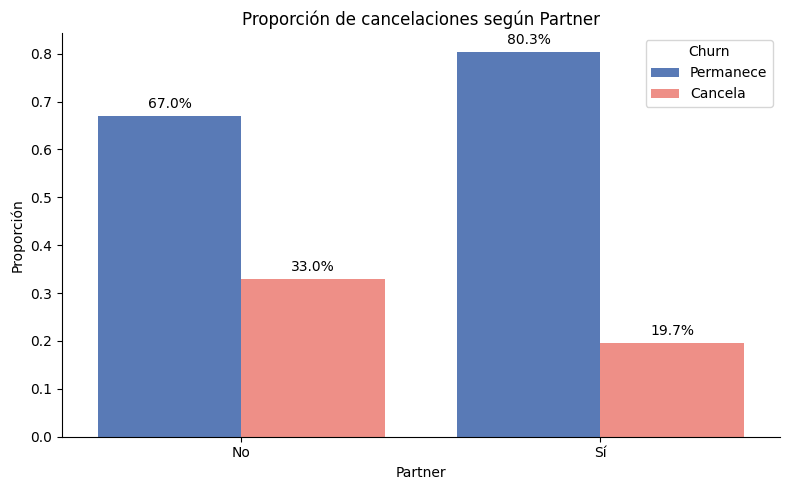

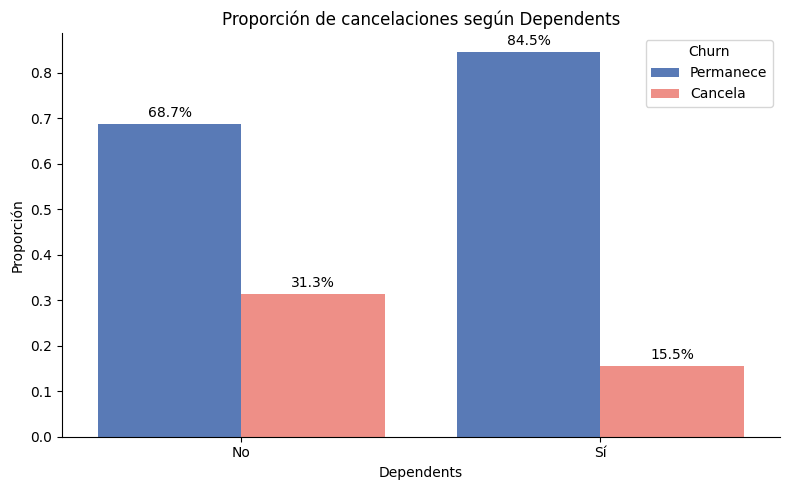

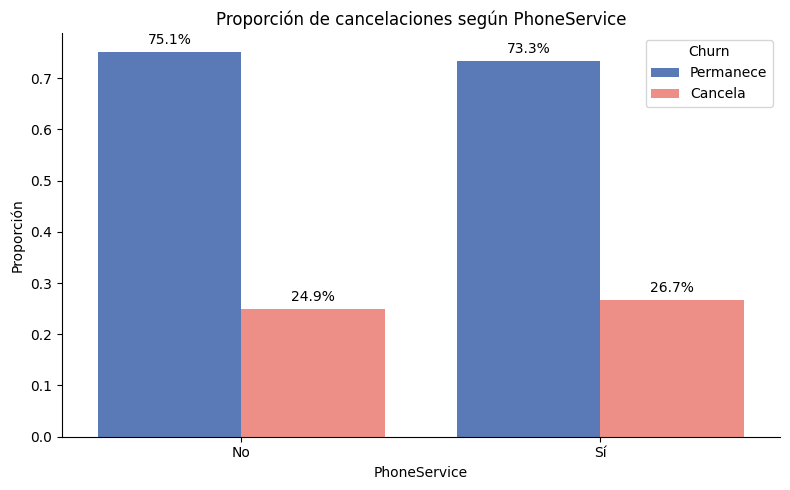

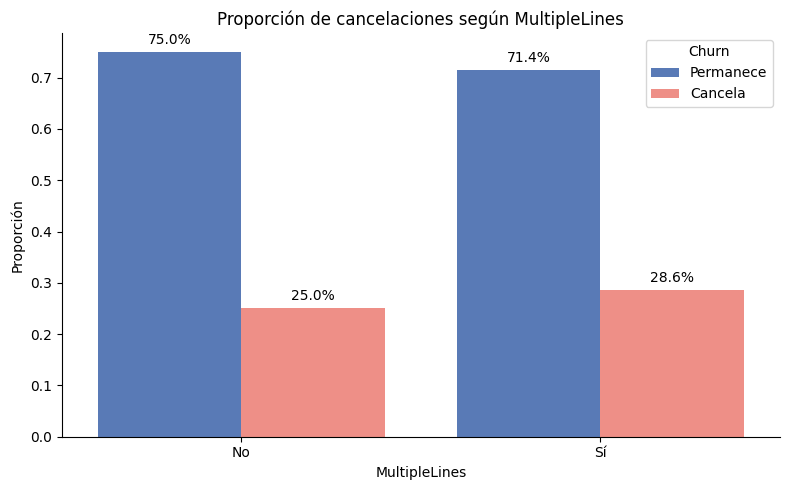

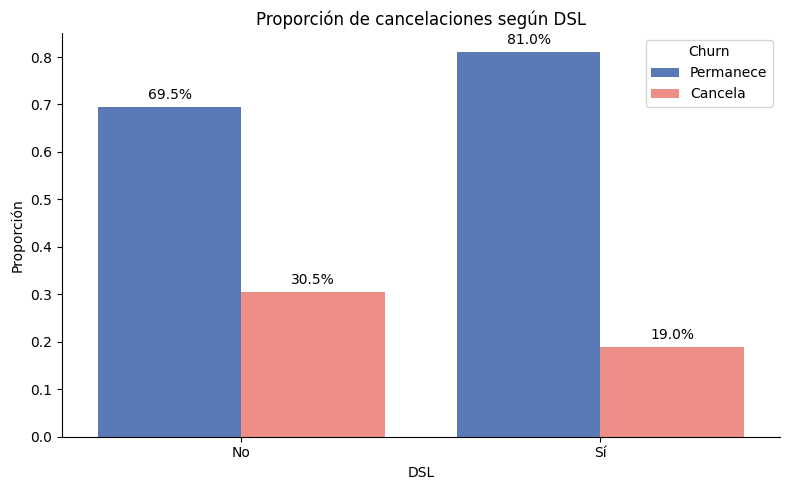

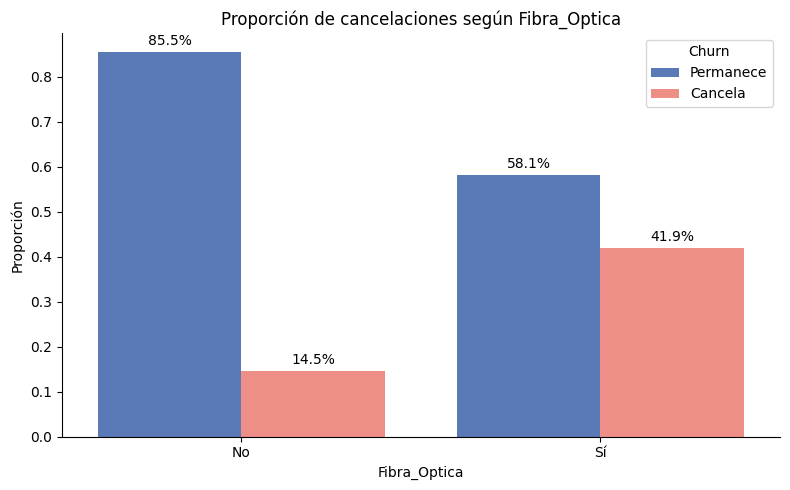

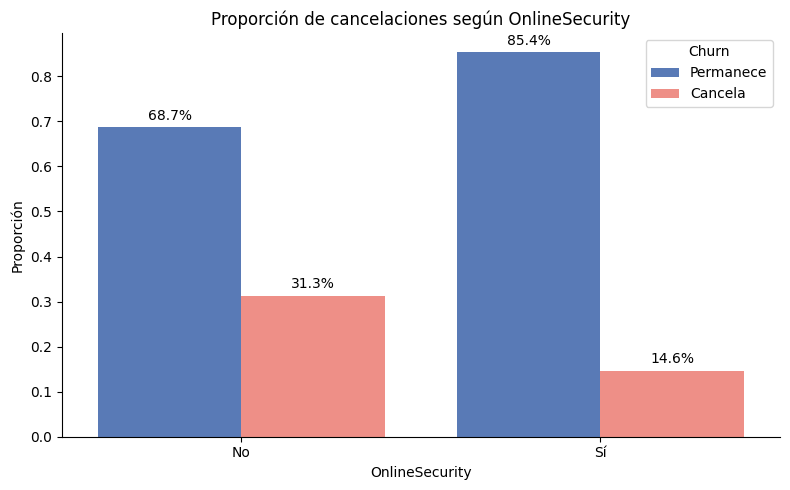

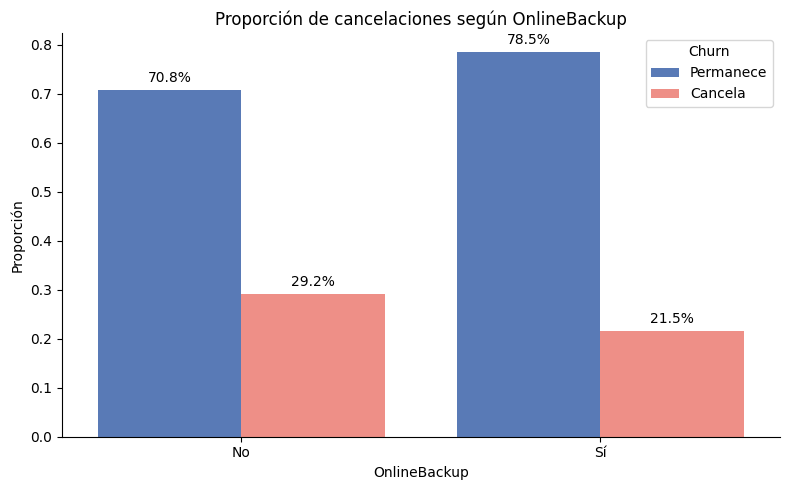

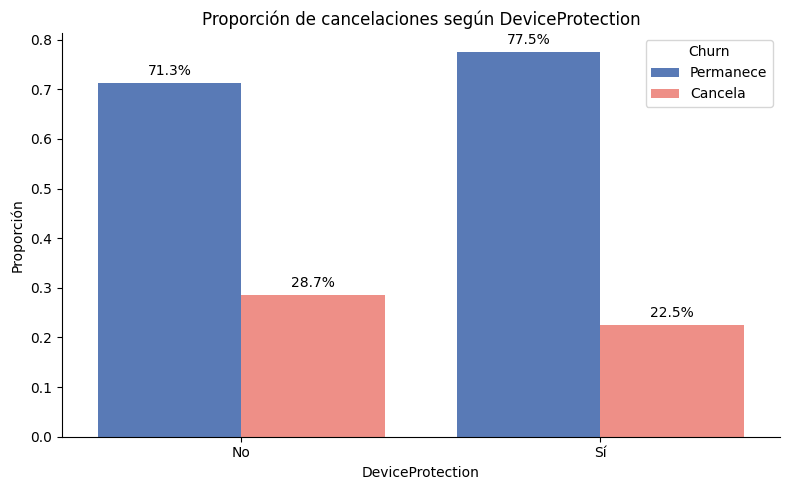

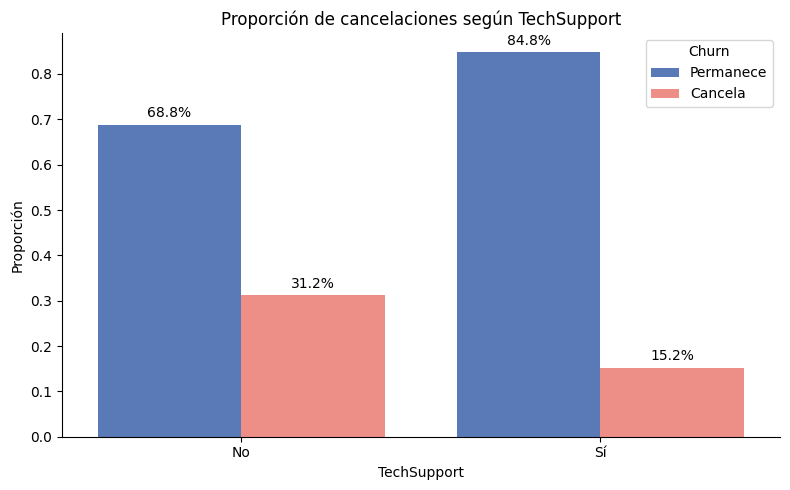

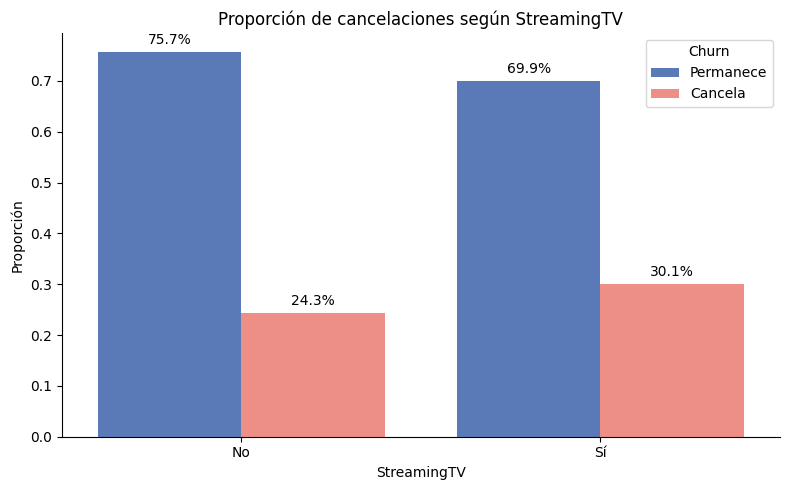

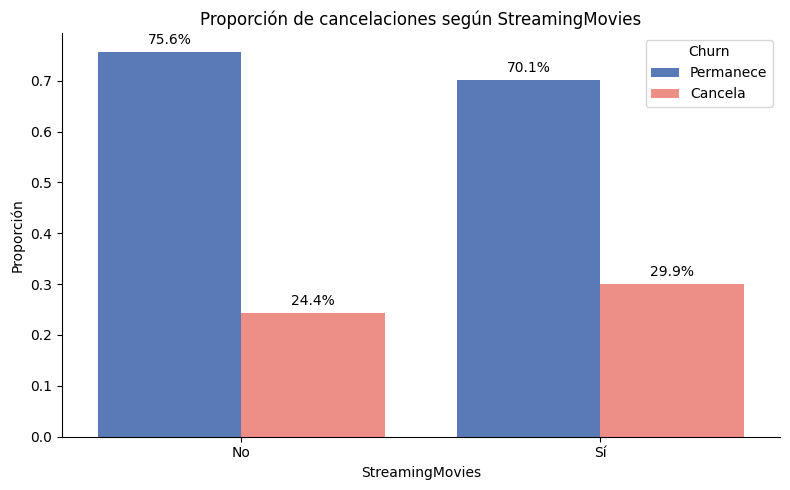

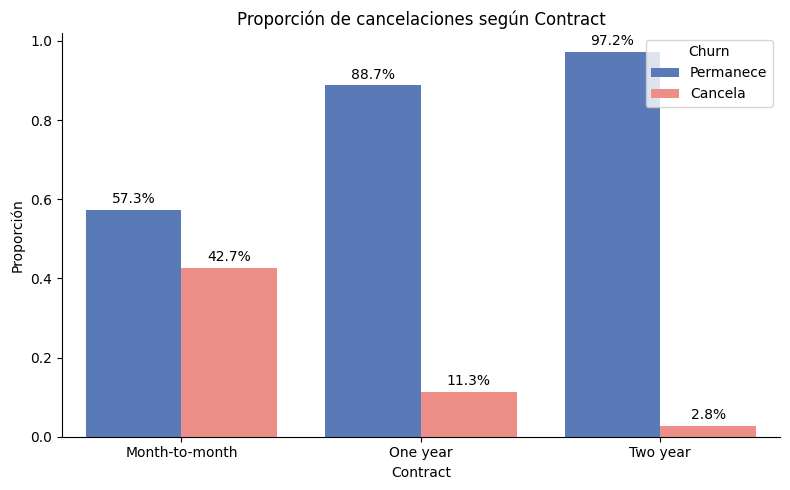

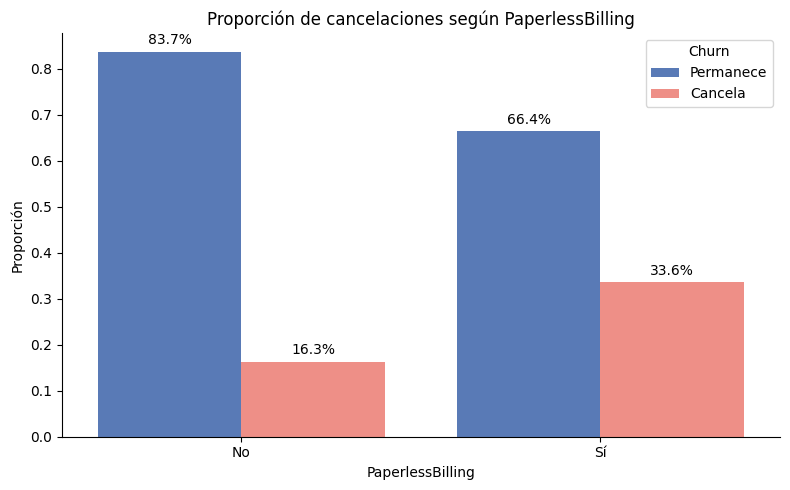

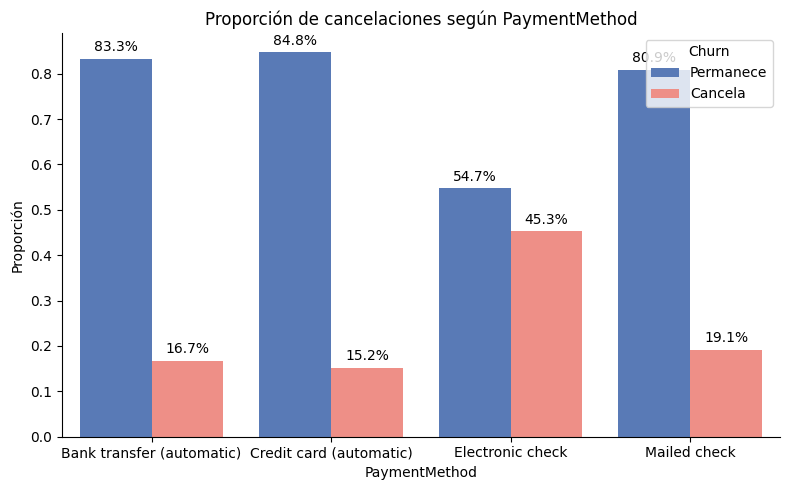

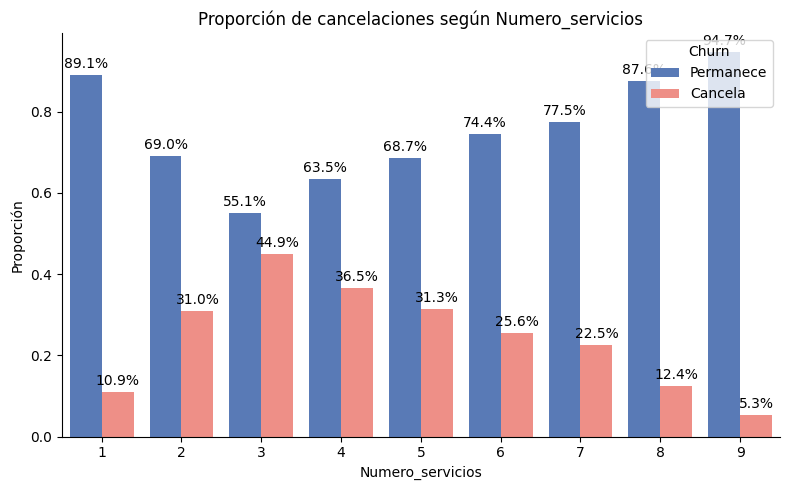

In [4]:
for columna in list(datos.columns):
  valores_unicos = len(datos[columna].unique())
  if valores_unicos <= len(datos['Numero_servicios'].unique()) and columna != 'Churn':
    grafico_columnas_categoricas(columna)

Este análisis permite identificar patrones como:
- Contratos más cortos presentan mayor tasa de cancelación.
- Algunos métodos de pago se asocian a una mayor probabilidad de churn.

---

### 2.2. Variables numéricas

Se analizan distribuciones de variables numéricas diferenciando clientes que cancelan y los que permanecen.

In [5]:
def boxplot_columnas_numericas(columna):

  etiquetas = datos['Churn'].map({0: 'Permanece', 1: 'Cancela'})

  plt.figure(figsize=(8, 5))
  box = sns.boxplot(
                    x=etiquetas,
                    y=datos[columna],
                    hue=etiquetas,
                    palette=palette,
                    width=0.5,
                    legend=False
                    )

  medias = datos.groupby(datos['Churn'].map({0: 'Permanece', 1: 'Cancela'}))[columna].mean()

  plt.title(f'Distribución del tiempo de permanencia según {columna}')
  plt.xlabel('Estado del cliente')
  plt.ylabel(columna)
  sns.despine()
  plt.tight_layout()
  plt.show()

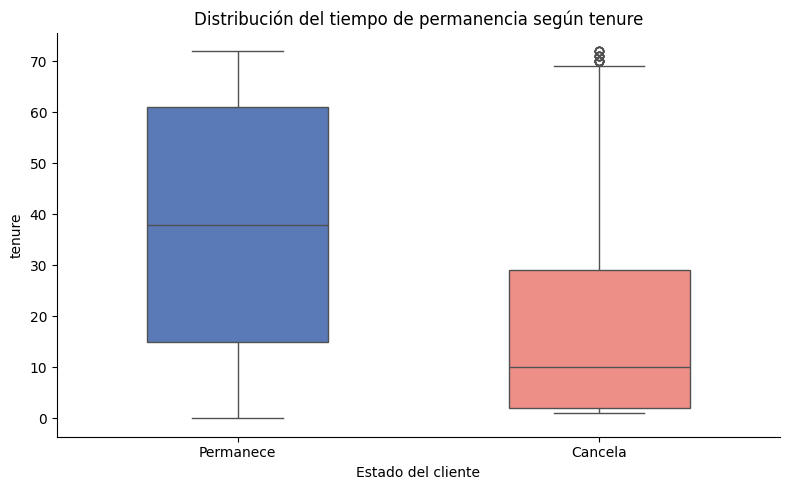

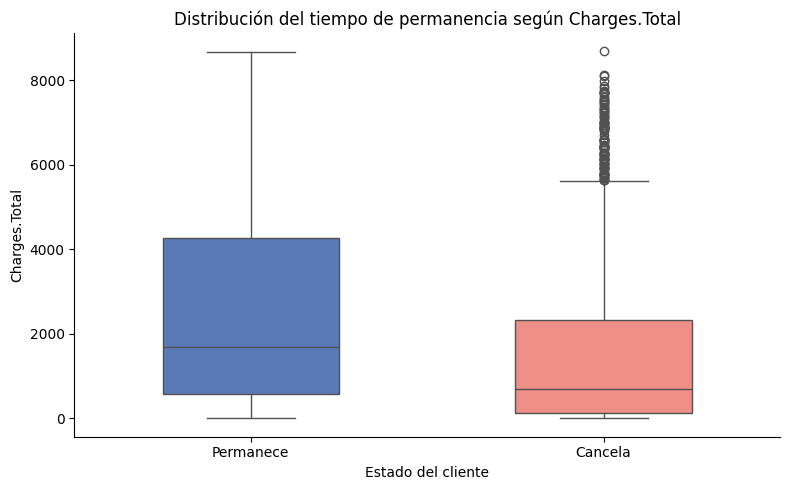

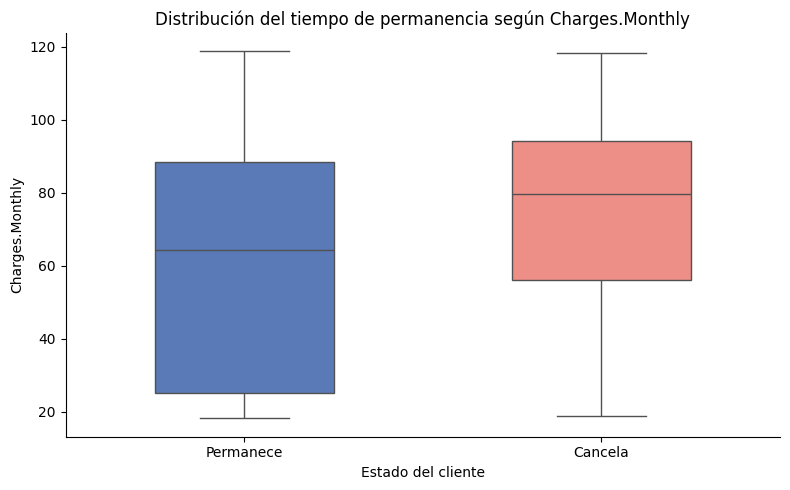

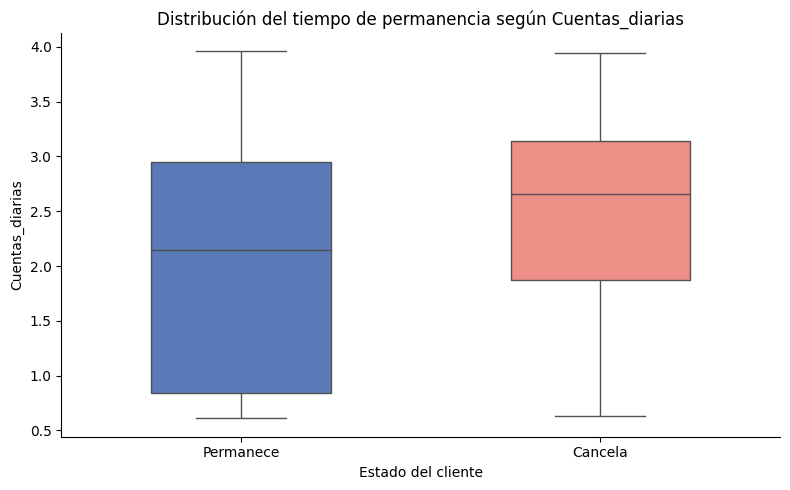

In [6]:
col_numericas = ['tenure','Charges.Total','Charges.Monthly','Cuentas_diarias']

for columna in col_numericas:
  boxplot_columnas_numericas(columna)

Se observa, por ejemplo:
- Clientes con mayor `tenure` tienden a permanecer.
- Mayores cargos mensuales se asocian a una leve mayor cancelación.

---

## 3. Análisis de Features

Se ajusta la columna `Cuentas_diarias` y se eliminan variables redundantes o poco relevantes y se codifican las variables categóricas para el modelado.

### 3.1. Ajuste de la columna Cuentas_diarias

Se comparó `Charges.Monthly` con `Charges.Total` / `tenure` para verificar la consistencia de los datos y detectar variaciones temporales en los cargos mensuales.

In [7]:
import numpy as np

diferencias = np.abs((datos['Charges.Total'] / datos['tenure']) - datos['Charges.Monthly'])

print("Diferencia media:", diferencias.mean())
print("Diferencia máxima:", diferencias.max())

Diferencia media: 1.7457572461221662
Diferencia máxima: 19.125000000000007


In [8]:
corr = datos[['Charges.Monthly', 'Charges.Total', 'tenure']].corr()
print(corr)

                 Charges.Monthly  Charges.Total    tenure
Charges.Monthly         1.000000       0.651174  0.247900
Charges.Total           0.651174       1.000000  0.826178
tenure                  0.247900       0.826178  1.000000


In [9]:
datos['Cuentas_diarias'] = datos['Charges.Total'] / (datos['tenure'].replace(0, 1) * 30)

La comparación mostró que existen pequeñas variaciones en los valores, por lo que `Cuentas_diarias` se considera una medida más robusta para representar el gasto promedio diario del cliente.

### 3.2. Eliminación inicial de columnas redundantes

`Female`: se elimina porque es redundante (Female = 1 - Male).

`Charges.Total`: se reemplaza por Cuentas_diarias.

`Numero_servicios`: es una variable derivada de otras, por lo que no se requiere de forma explícita.


In [10]:
columnas_eliminar = ['Female','Charges.Total','Numero_servicios']
datos.drop(columns=columnas_eliminar,axis=1,inplace=True)

In [11]:
datos.head()

,Churn,Male,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,DSL,Fibra_Optica,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Cuentas_diarias
0,0,0,0,1,1,9,1,0,1,0,...,1,0,1,1,0,One year,1,Mailed check,65.6,2.197407
1,0,1,0,0,0,9,1,1,1,0,...,0,0,0,0,1,Month-to-month,0,Mailed check,59.9,2.008889
2,1,1,0,0,0,4,1,0,0,1,...,0,1,0,0,0,Month-to-month,1,Electronic check,73.9,2.340417
3,1,1,1,1,0,13,1,0,0,1,...,1,1,0,1,1,Month-to-month,1,Electronic check,98.0,3.173974
4,1,0,1,1,0,3,1,0,0,1,...,0,0,1,1,0,Month-to-month,1,Mailed check,83.9,2.971111


### 3.3. Codificación de variables categóricas

Se transformaron las variables categóricas en variables binarias mediante pd.get_dummies.

In [12]:
categoricas = ['Contract', 'PaymentMethod']

datos_codificados = pd.get_dummies(data=datos,columns=categoricas,dtype=int)
datos_codificados.sample(5)

,Churn,Male,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,DSL,Fibra_Optica,...,PaperlessBilling,Charges.Monthly,Cuentas_diarias,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6884,0,1,0,1,0,31,1,1,0,1,...,0,88.65,2.885161,1,0,0,0,1,0,0
2253,0,0,1,1,0,72,1,1,1,0,...,0,89.10,2.940926,0,0,1,0,1,0,0
6357,1,0,1,0,0,11,1,0,0,1,...,0,89.70,3.174848,1,0,0,1,0,0,0
2493,0,0,0,0,0,24,1,1,0,1,...,1,84.35,2.691736,1,0,0,0,0,1,0
3610,0,1,0,0,0,31,1,0,0,0,...,0,20.45,0.686613,0,0,1,0,0,0,1


### 3.4. Análisis de correlación

Se calculó la matriz de correlación para identificar relaciones entre variables y con la variable objetivo `Churn`.

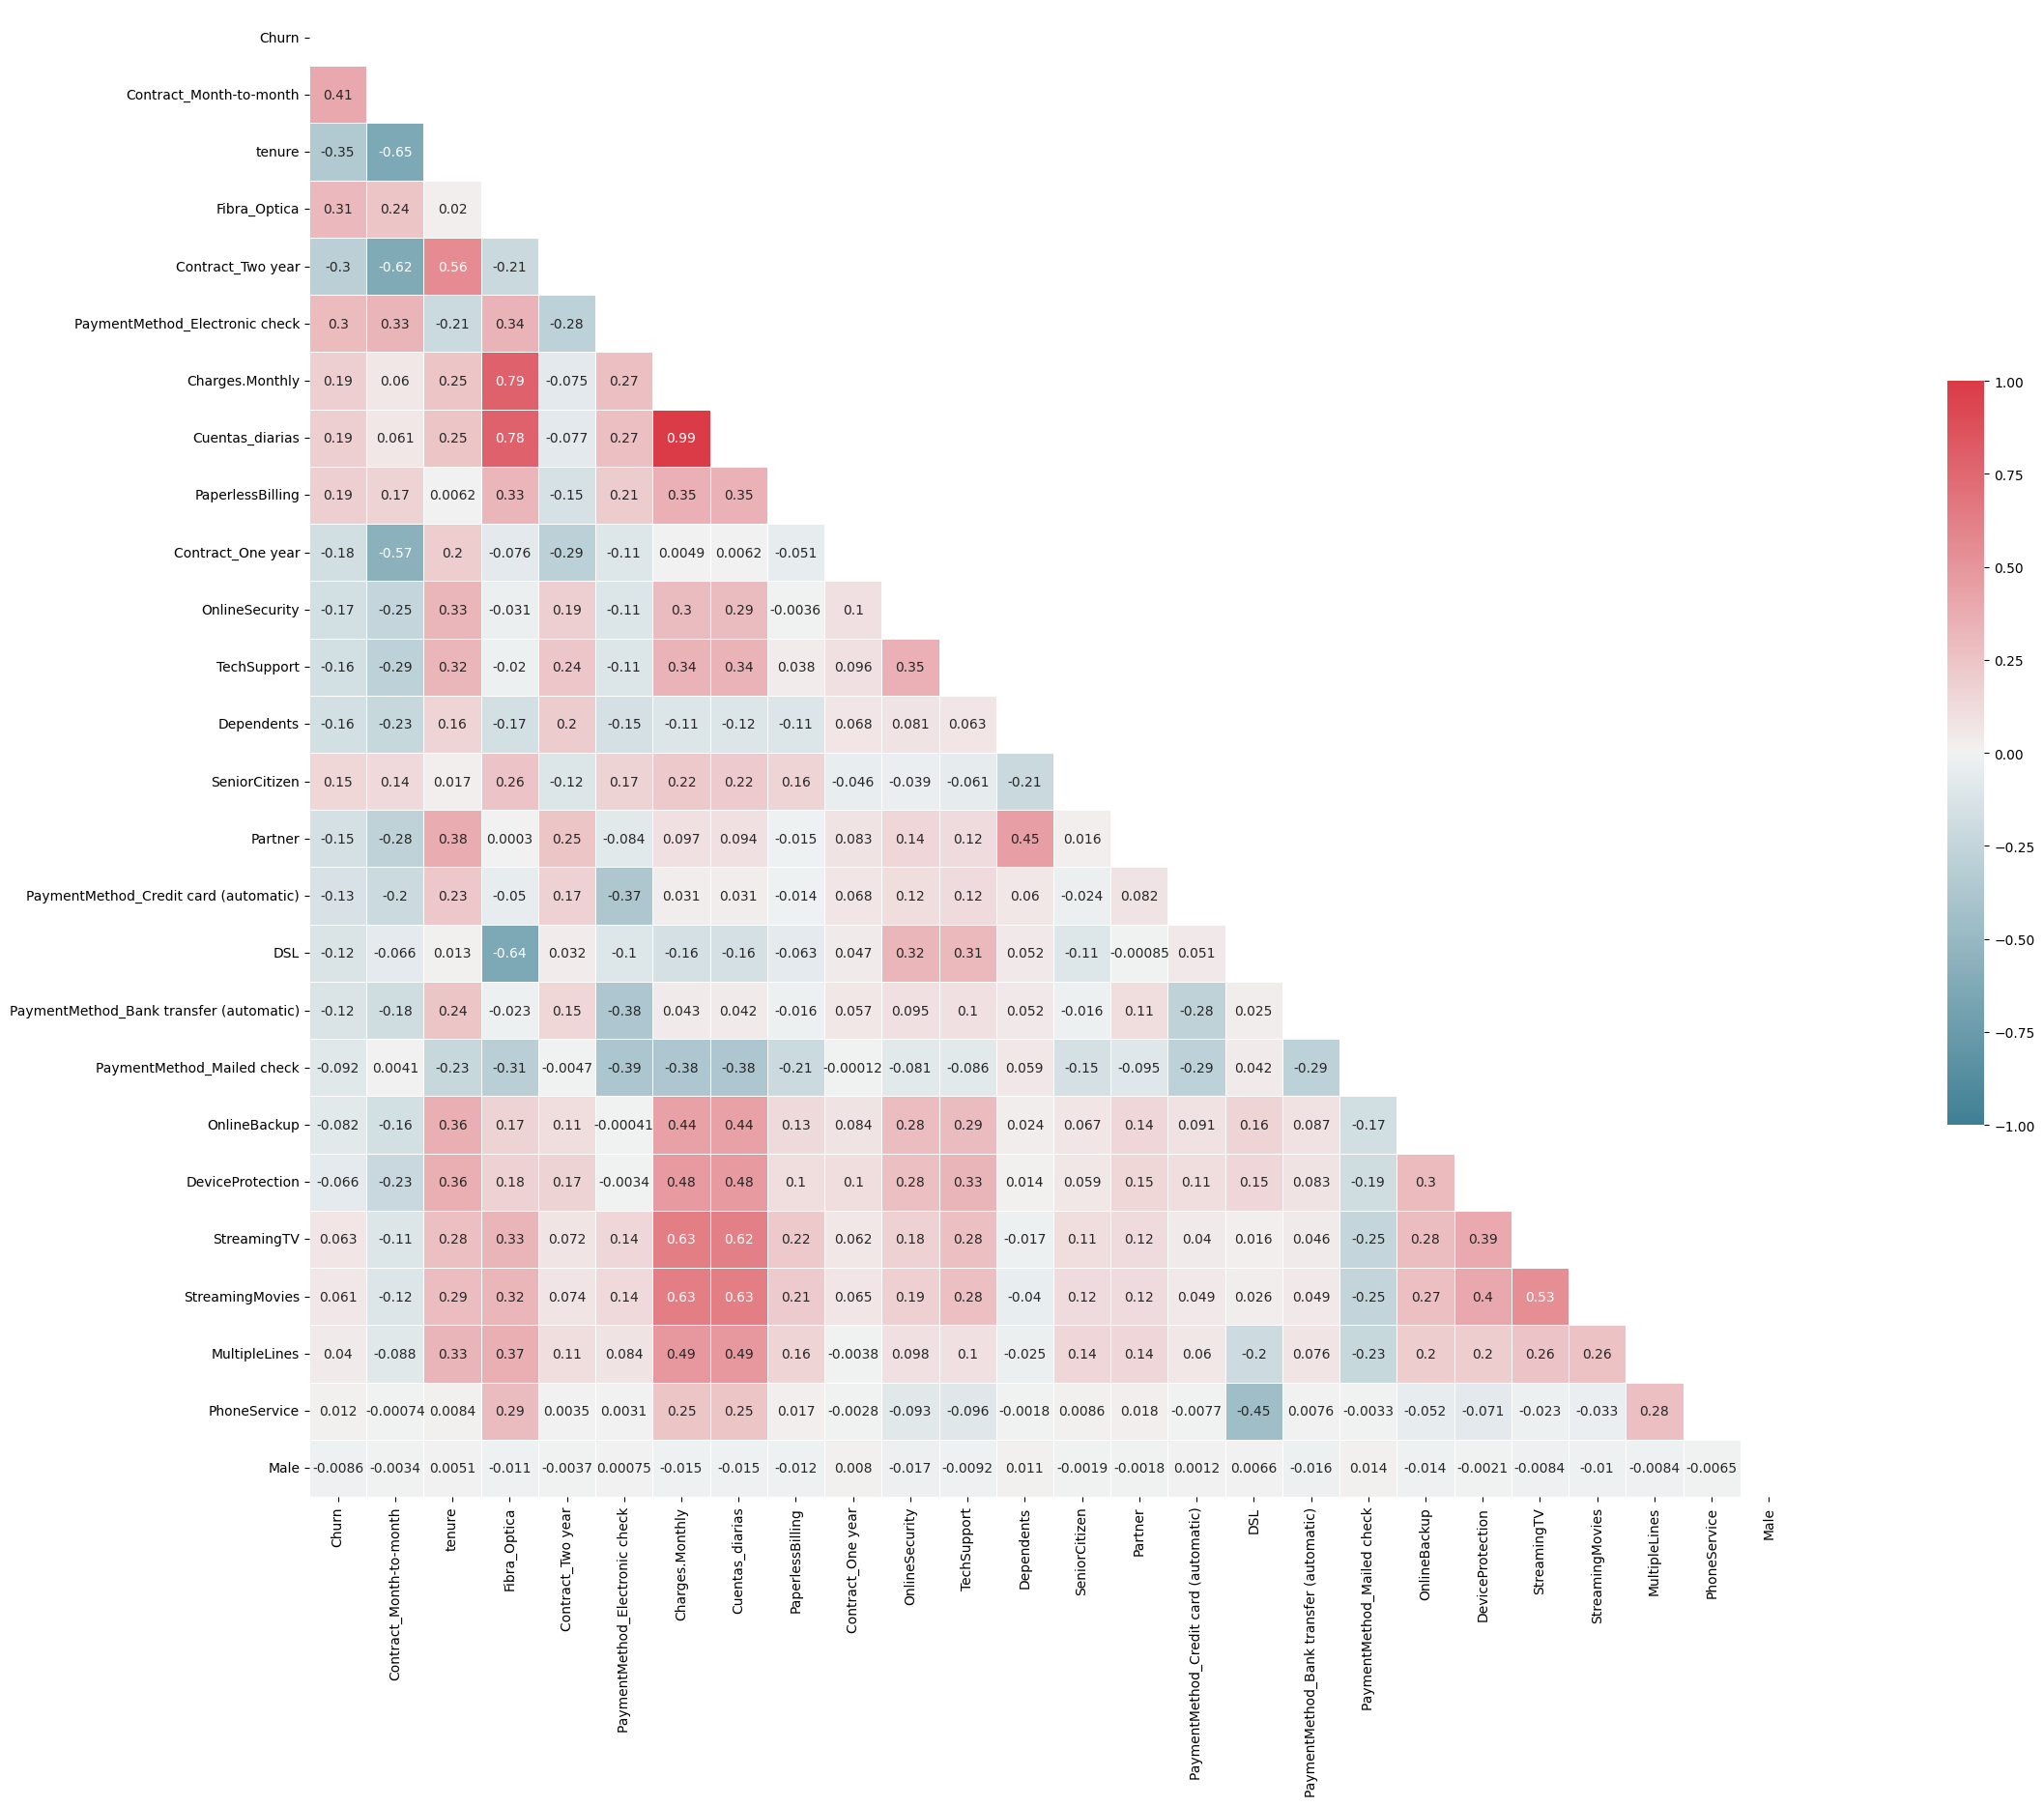

In [13]:
corr = datos_codificados.corr().sort_values(by='Churn', ascending=False)
orden_columnas = corr['Churn'].abs().sort_values(ascending=False).index
corr_ordenado = corr.loc[orden_columnas, orden_columnas]

# Generar una máscara para el triángulo superior
mascara = np.zeros_like(corr_ordenado, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(40, 20))

# Generar el mapa de calor (heatmap)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr_ordenado, mask=mascara, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
# Mostrar el mapa de calor (heatmap)
plt.show()


### 3.5. Eliminación de variables poco relevantes

Tras revisar la matriz de correlación, se observó que `Male` tenía una correlación muy baja con todas las variables, incluyendo `Churn`, por lo que se eliminó por baja relevancia estadística.

In [14]:
datos_codificados.drop(columns='Male',axis=1,inplace=True)

Con estos pasos, se redujo la redundancia, se mejoró la representatividad de variables numéricas y se eliminaron atributos con poca capacidad predictiva. Esto deja el dataset más limpio y enfocado para la etapa de modelado.

---

In [15]:
datos_codificados.head()

,Churn,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,DSL,Fibra_Optica,OnlineSecurity,...,PaperlessBilling,Charges.Monthly,Cuentas_diarias,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,1,9,1,0,1,0,0,...,1,65.6,2.197407,0,1,0,0,0,0,1
1,0,0,0,0,9,1,1,1,0,0,...,0,59.9,2.008889,1,0,0,0,0,0,1
2,1,0,0,0,4,1,0,0,1,0,...,1,73.9,2.340417,1,0,0,0,0,1,0
3,1,1,1,0,13,1,0,0,1,0,...,1,98.0,3.173974,1,0,0,0,0,1,0
4,1,1,1,0,3,1,0,0,1,0,...,1,83.9,2.971111,1,0,0,0,0,0,1


## 4. Verificación de la Proporción de Cancelación (Churn)

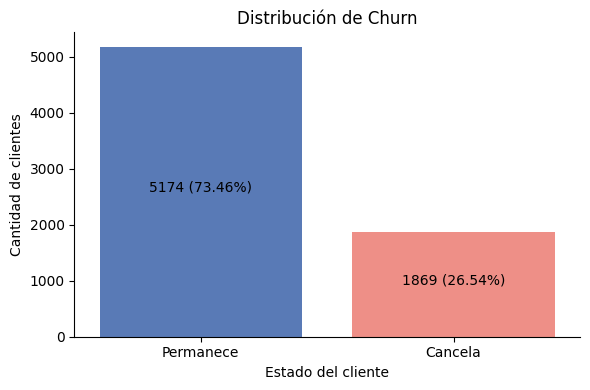

In [16]:
churn_by = datos_codificados.Churn.value_counts().reset_index()
churn_by['Churn'] = churn_by['Churn'].map({0: 'Permanece', 1: 'Cancela'})

percentages = (churn_by['count'] / churn_by['count'].sum() * 100).round(2)

plt.figure(figsize=(6, 4))
ax = sns.barplot(
    x='Churn',
    y='count',
    hue='Churn',
    data=churn_by,
    palette=palette
)

plt.title('Distribución de Churn')
plt.ylabel('Cantidad de clientes')
plt.xlabel('Estado del cliente')

# Añadir texto a cada barra
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height/2,
        f"{churn_by['count'][i]} ({percentages[i]}%)",
        ha='center'
    )

sns.despine()
plt.tight_layout()
plt.show()


Se aprecia que los datos están desbalanceados: 73.46% de los clientes permanecen y 26.54% cancelan, lo que indica un desequilibrio de clases que debe considerarse al entrenar los modelos.

---

## 5. Modelado

Se separan los datos dejando un 20% para test, se balancea con SMOTE y se prueba un modelo baseline (*Logistic Regression*).


In [17]:
X = datos_codificados.drop(columns='Churn', axis=1)
y = datos_codificados['Churn']

In [18]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X,y,test_size=0.20,stratify=y,random_state=230)

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=230)
X_res, y_res = smote.fit_resample(X, y)
y_res.value_counts()

,count
Churn,
0,4139
1,4139


In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_res,y_res,test_size=0.25,stratify=y_res,random_state=230)

### 5.1 Modelo Base (Logistic Regression)

Como línea base se entrena un modelo de **Regresión Logística** con datos escalados, para establecer un punto de referencia de rendimiento.

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [23]:
baseline = LogisticRegression(max_iter=3000, random_state=230)
baseline.fit(X_train_scaled, y_train)
y_pred_baseline = baseline.predict(X_val_scaled)

In [24]:
print(f"Exactitud (accuracy):       {accuracy_score(y_val, y_pred_baseline):.4f}")
print(f"Precisión (precision):      {precision_score(y_val, y_pred_baseline):.4f}")
print(f"Sensibilidad (recall):      {recall_score(y_val, y_pred_baseline):.4f}")
print(f"F1-score:                   {f1_score(y_val, y_pred_baseline):.4f}")

Exactitud (accuracy):       0.8275
Precisión (precision):      0.8343
Sensibilidad (recall):      0.8174
F1-score:                   0.8258


La regresión logística sirve como punto de comparación: cualquier modelo posterior debe superar estas métricas para justificar su complejidad.

---

### 5.2 Matriz de Confusión - Baseline

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def matriz_confusion(y_val, y_pred,nombre_modelo):
  matriz_confusion = confusion_matrix(y_val, y_pred)
  visualizacion = ConfusionMatrixDisplay(confusion_matrix = matriz_confusion,
                                        display_labels = ['Permanece','Cancela'])
  visualizacion.plot(cmap='cividis')
  plt.title(f'Matriz de Confusión - {nombre_modelo}')
  plt.show()

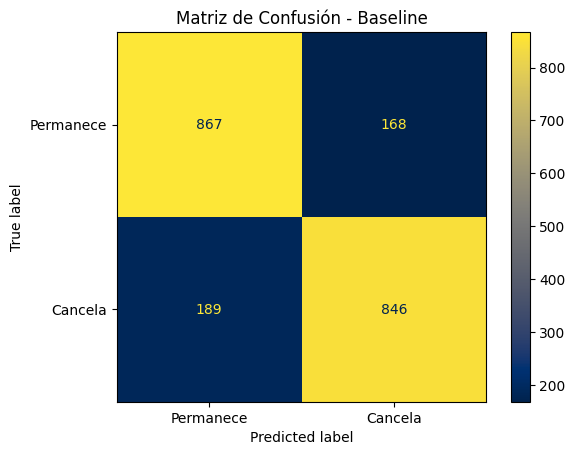

In [26]:
matriz_confusion(y_val, y_pred_baseline,'Baseline')

---

## 6. Comparación de Modelos

Se prueban tres algoritmos supervisados:
- **Árbol de Decisión**
- **Random Forest**
- **KNN**

Cada uno se entrena con los mismos datos para una comparación justa.

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [28]:
modelo_arbol = DecisionTreeClassifier(max_depth=8, random_state=230)
modelo_arbol.fit(X_train, y_train)
y_pred_arbol = modelo_arbol.predict(X_val)

modelo_forest = RandomForestClassifier(max_depth=8, random_state=230)
modelo_forest.fit(X_train, y_train)
y_pred_forest = modelo_forest.predict(X_val)

modelo_knn = KNeighborsClassifier()
modelo_knn.fit(X_train_scaled, y_train)
y_pred_knn = modelo_knn.predict(X_val_scaled)

### 6.1 Métricas de los modelos

In [29]:
def obtener_metricas(nombre, y_val, y_pred):
    return {
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred, zero_division=0),
        "Recall": recall_score(y_val, y_pred, zero_division=0),
        "F1 Score": f1_score(y_val, y_pred, zero_division=0)
    }

resultados = [
    obtener_metricas("Decision Tree", y_val, y_pred_arbol),
    obtener_metricas("Random Forest", y_val, y_pred_forest),
    obtener_metricas("KNN", y_val, y_pred_knn)
]

df_resultados = pd.DataFrame(resultados).sort_values(by="F1 Score", ascending=False)
print(df_resultados.round(4))

          Modelo  Accuracy  Precision  Recall  F1 Score
0  Decision Tree    0.8237     0.8079  0.8493    0.8281
1  Random Forest    0.8169     0.7929  0.8580    0.8241
2            KNN    0.8145     0.7973  0.8435    0.8197


En general:
- **Random Forest** tiende a destacar en equilibrio entre *Recall* y *Precision*.
- **Árbol de Decisión** es más simple pero menos robusto.
- **KNN** depende fuertemente de la escala de variables y puede ser menos estable.

In [30]:
from sklearn.metrics import classification_report

In [31]:
print(f'MODELO ARBOL:\n{classification_report(y_val, y_pred_arbol)}\n')
print(f'MODELO RANDOM FOREST:\n{classification_report(y_val, y_pred_forest)}\n')
print(f'MODELO KNN:\n{classification_report(y_val, y_pred_knn)}')

MODELO ARBOL:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1035
           1       0.81      0.85      0.83      1035

    accuracy                           0.82      2070
   macro avg       0.82      0.82      0.82      2070
weighted avg       0.82      0.82      0.82      2070


MODELO RANDOM FOREST:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1035
           1       0.79      0.86      0.82      1035

    accuracy                           0.82      2070
   macro avg       0.82      0.82      0.82      2070
weighted avg       0.82      0.82      0.82      2070


MODELO KNN:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1035
           1       0.80      0.84      0.82      1035

    accuracy                           0.81      2070
   macro avg       0.82      0.81      0.81      2070
weighted avg       0.82 

### 6.2 Matrices de confusión para cada modelo

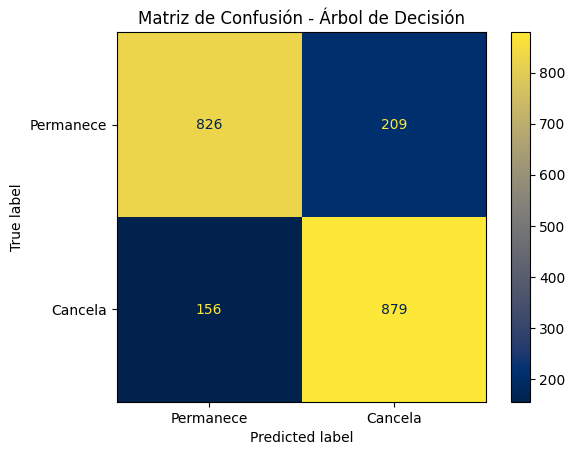

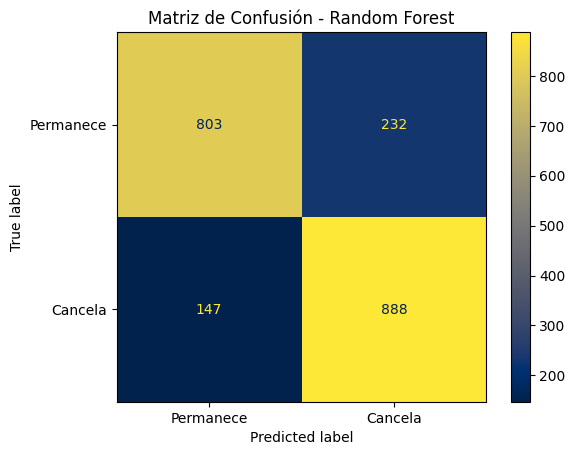

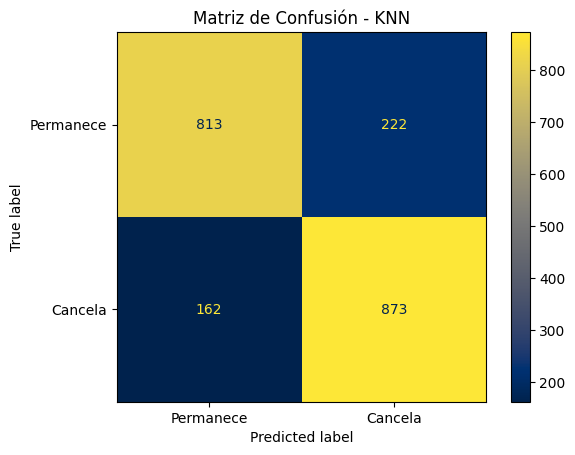

In [32]:
matriz_confusion(y_val, y_pred_arbol,'Árbol de Decisión')
matriz_confusion(y_val, y_pred_forest,'Random Forest')
matriz_confusion(y_val, y_pred_knn,'KNN')

## 7. Importancia de Variables

Se utiliza el **Random Forest** para medir la contribución relativa de cada variable en la predicción del churn.

                                   Features  Importances
0                                    tenure        12.49
1                         Contract_Two year        12.40
2                   Contract_Month-to-month        10.82
3                         Contract_One year         8.66
4                           Cuentas_diarias         7.61
5                           Charges.Monthly         7.52
6                               TechSupport         5.70
7                              Fibra_Optica         5.67
8                                Dependents         4.91
9                            OnlineSecurity         4.56
10                                  Partner         2.97
11    PaymentMethod_Credit card (automatic)         2.79
12                             OnlineBackup         2.41
13               PaymentMethod_Mailed check         2.10
14  PaymentMethod_Bank transfer (automatic)         1.97
15                                      DSL         1.66
16                         Devi

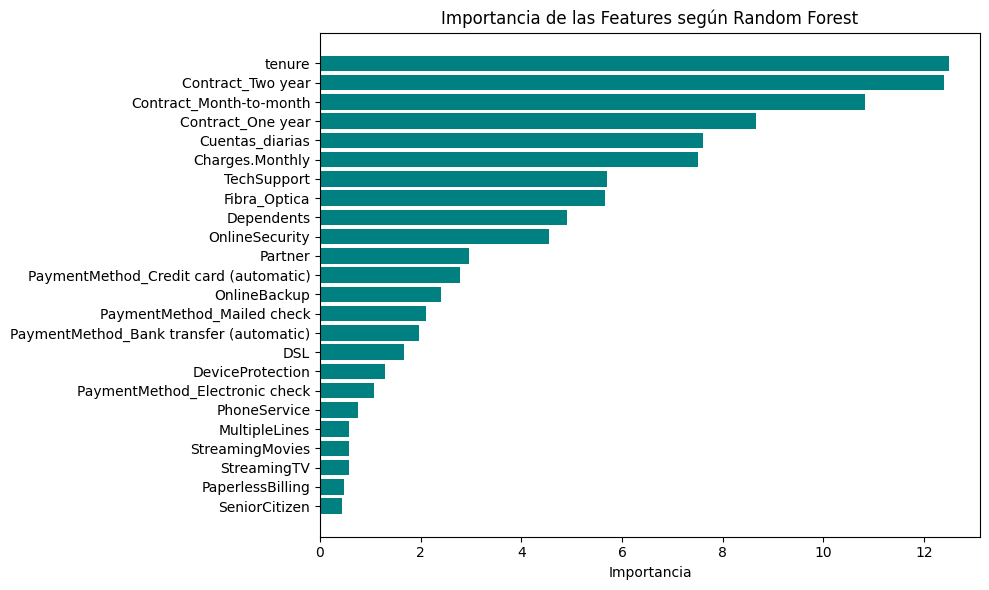

In [33]:
importances = modelo_forest.feature_importances_

feature_importances = pd.DataFrame({'Features': X_train.columns, 'Importances': (importances*100).round(2)}).sort_values('Importances',ascending=False).reset_index(drop=True)
print(feature_importances)

# Gráfico
plt.figure(figsize=(10,6))
plt.barh(feature_importances['Features'], feature_importances['Importances'], color='teal')
plt.xlabel('Importancia')
plt.title('Importancia de las Features según Random Forest')
plt.gca().invert_yaxis()  # para ver de mayor a menor arriba
plt.tight_layout()
plt.show()

## 8. Selección de Variables y Validación Cruzada

Se prueban diferentes cantidades de features para evaluar el impacto en el rendimiento del modelo.

In [34]:
resultados_clasificacion = pd.DataFrame(index=['Accuracy', 'Precision', 'Recall', 'F1'])

ct_features = [i if i != 0 else 1 for i in range(0, len(feature_importances)+1, 4)]

for i in ct_features:
    selected_features = feature_importances['Features'].values[:i]
    X_train_sel = X_train[selected_features]
    X_val_sel = X_val[selected_features]

    modelo_forest.fit(X_train_sel, y_train)
    y_pred_sel = modelo_forest.predict(X_val_sel)

    resultados_clasificacion[i] = [
        accuracy_score(y_val, y_pred_sel),
        precision_score(y_val, y_pred_sel, zero_division=0),
        recall_score(y_val, y_pred_sel, zero_division=0),
        f1_score(y_val, y_pred_sel, zero_division=0)
    ]

resultados_clasificacion

,1,4,8,12,16,20,24
Accuracy,0.657488,0.749758,0.814976,0.813527,0.827053,0.822705,0.816908
Precision,0.654356,0.695685,0.789007,0.793135,0.804680,0.802536,0.796029
Recall,0.667633,0.887923,0.859903,0.848309,0.863768,0.856039,0.852174
F1,0.660928,0.780136,0.822931,0.819795,0.833178,0.828424,0.823145


In [35]:
resultados_clasificacion = pd.DataFrame(index=['Accuracy', 'Precision', 'Recall', 'F1'])
ct_features = range(20,25)

for i in ct_features:
    selected_features = feature_importances['Features'].values[:i]
    X_train_sel = X_train[selected_features]
    X_val_sel = X_val[selected_features]

    modelo_forest.fit(X_train_sel, y_train)
    y_pred_sel = modelo_forest.predict(X_val_sel)

    resultados_clasificacion[i] = [
        accuracy_score(y_val, y_pred_sel),
        precision_score(y_val, y_pred_sel, zero_division=0),
        recall_score(y_val, y_pred_sel, zero_division=0),
        f1_score(y_val, y_pred_sel, zero_division=0)
    ]

resultados_clasificacion

,20,21,22,23,24
Accuracy,0.822705,0.822705,0.822222,0.824638,0.816908
Precision,0.802536,0.798214,0.796972,0.802158,0.796029
Recall,0.856039,0.863768,0.864734,0.861836,0.852174
F1,0.828424,0.829698,0.829472,0.830927,0.823145


Se observa que mantener entre **20 y 22 variables** mantiene un rendimiento estable sin pérdida significativa de capacidad predictiva.

---

## 9. Validación Cruzada

Se realiza validación cruzada con 22 features seleccionadas para confirmar la estabilidad del modelo.

In [36]:
selected_features = feature_importances['Features'].values[:22]
X_selected_features = X[selected_features]

In [37]:
X_selected_features

,tenure,Contract_Two year,Contract_Month-to-month,Contract_One year,Cuentas_diarias,Charges.Monthly,TechSupport,Fibra_Optica,Dependents,OnlineSecurity,...,OnlineBackup,PaymentMethod_Mailed check,PaymentMethod_Bank transfer (automatic),DSL,DeviceProtection,PaymentMethod_Electronic check,PhoneService,MultipleLines,StreamingMovies,StreamingTV
3148,56,1,0,0,0.859554,25.95,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
5327,69,1,0,0,2.430435,74.10,1,0,0,1,...,0,0,0,1,1,0,1,1,1,0
497,69,1,0,0,3.257754,97.65,1,1,0,0,...,1,0,0,0,1,0,1,1,0,1
6048,1,0,1,0,0.650000,19.50,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1999,69,1,0,0,2.992319,86.90,1,0,1,1,...,0,0,1,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,51,0,0,1,3.162843,93.65,0,1,0,1,...,0,0,1,0,1,0,1,1,1,0
2334,36,0,0,1,1.845231,54.10,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0
3224,8,0,1,0,0.943542,30.45,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
6599,54,0,0,1,2.293611,70.15,0,0,0,0,...,0,0,0,1,0,0,1,1,1,1


In [38]:
X_train,X_val,y_train,y_val = train_test_split(X_selected_features,y,stratify=y,random_state=230)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [39]:
from sklearn.model_selection import KFold, cross_validate

In [40]:
kf = KFold(n_splits=5, shuffle = True, random_state = 230)
cv_resultados = cross_validate(modelo_forest, X_train_res, y_train_res, cv=kf, scoring = ['accuracy','recall', 'precision', 'f1'])
cv_resultados = pd.DataFrame(cv_resultados).drop(columns=['fit_time','score_time'])
cv_resultados.mean()

,0
test_accuracy,0.828608
test_recall,0.875737
test_precision,0.800226
test_f1,0.836210


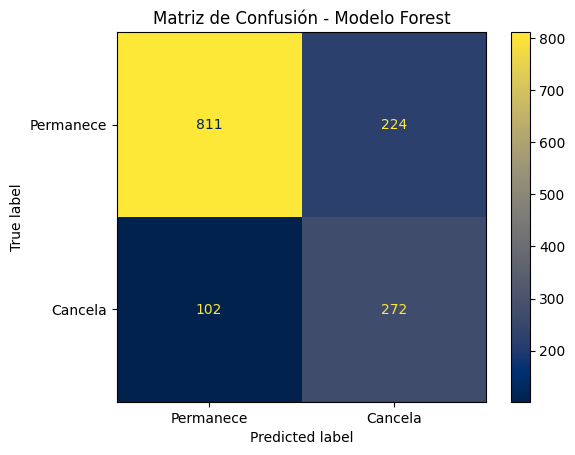

In [41]:
modelo_forest.fit(X_train_res, y_train_res)
y_previsto = modelo_forest.predict(X_val)
matriz_confusion(y_val, y_previsto,'Modelo Forest')

---

## 10. Optimización de Hiperparámetros con GridSearchCV

Se optimiza el modelo de Random Forest buscando maximizar el **F1 Score**.

In [43]:
from sklearn.model_selection import GridSearchCV

# Definición del grid de hiperparámetros
param_grid = {
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [100, 200, 300]
}

# Configuración del GridSearch con validación cruzada y optimización de recall
grid = GridSearchCV(
    estimator=modelo_forest,
    param_grid=param_grid,
    cv=kf,
    scoring='f1',
    n_jobs=-1,         # Usa todos los núcleos disponibles (más rápido)
    verbose=1          # Muestra progreso
)

# Ajuste del modelo con los datos de entrenamiento
grid.fit(X_train_res, y_train_res)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:",grid.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


---

## 11. Evaluación del Modelo Optimizado

Se entrena el modelo con los mejores parámetros encontrados y se evalúa en el conjunto de validación.


In [44]:
params = grid.best_params_

modelo_mejorado = RandomForestClassifier(**params, random_state=230)
modelo_mejorado.fit(X_train_res, y_train_res)
y_pred_grid = modelo_mejorado.predict(X_val)

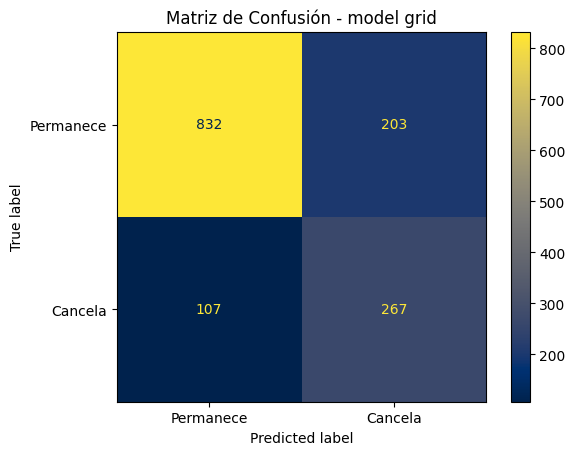

In [45]:
matriz_confusion(y_val, y_pred_grid,'model grid')

In [46]:
X_test_selected = X_test[selected_features]
y_test_pred = grid.predict(X_test_selected)
obtener_metricas(modelo_mejorado, y_test, y_test_pred)

{'Modelo': RandomForestClassifier(max_depth=10, random_state=230),
 'Accuracy': 0.7842441447835344,
 'Precision': 0.5757575757575758,
 'Recall': 0.7112299465240641,
 'F1 Score': 0.6363636363636364}

---

